# Pre-processing

In [1]:
setwd("/group/gilbert-lab/Lutz/Cadaver/phyloseq_files")

In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(picante)

#### Create phyloseq object

Non-transformed (for alpha diversity)

In [11]:
setwd("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/final_biom/")

biom <- import_biom("ItalianCadaver_deblur.biom")
map <- import_qiime_sample_data("mapfile_metadata.txt")
tree <- read_tree("rep_phylo.tre")
cadaver_nt <- merge_phyloseq(biom,tree,map)
cadaver_nt <- prune_samples(sample_sums(cadaver_nt) > 1000, cadaver_nt)

saveRDS(cadaver_nt, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver_nt.rds")

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [9]:
cadaver_nt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 701 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 20 sample variables ]
tax_table()   Taxonomy Table:    [ 701 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 701 tips and 699 internal nodes ]

Transform and filter data (for beta diversity and relative abundance)

In [12]:
biom <- import_biom("ItalianCadaver_deblur.biom")
map <- import_qiime_sample_data("mapfile_metadata.txt")
tree <- read_tree("rep_phylo.tre")
cadaver <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

saveRDS(cadaver, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver.rds")

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [6]:
cadaver_nt = readRDS("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver_nt.rds")
cadaver = readRDS("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver.rds")

## Summarize sequencing depths, in general and by category

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


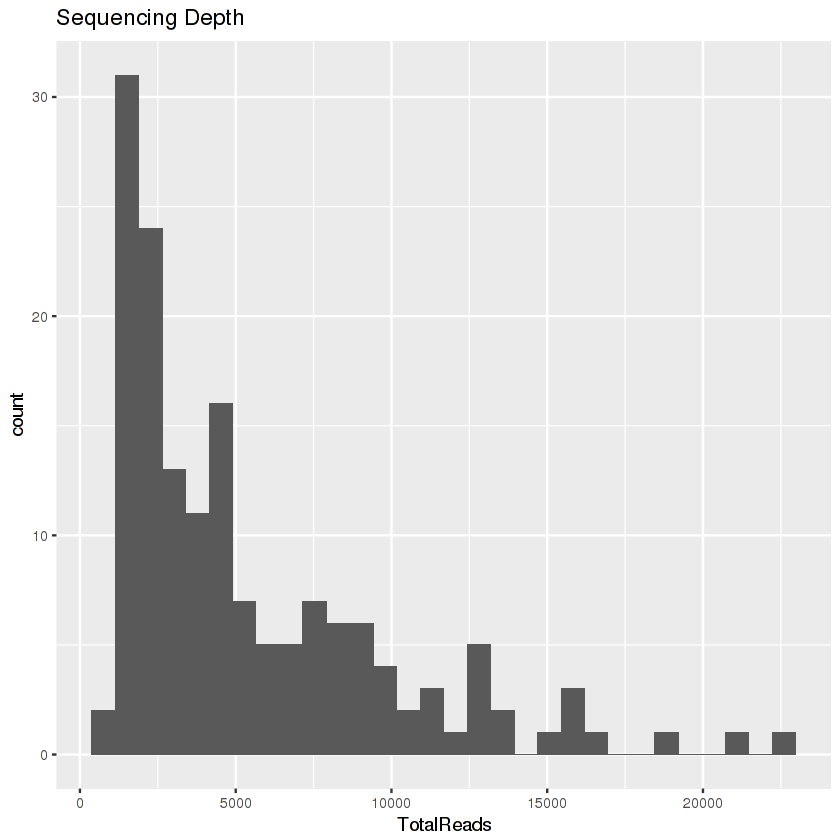

In [11]:
cadaver_nt = readRDS("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver_nt.rds")
sdt = data.table(as(sample_data(cadaver_nt), "data.frame"),
                 TotalReads = sample_sums(cadaver_nt), keep.rownames = TRUE)
setnames(sdt, "rn", "SampleID")
pSeqDepth = ggplot(sdt, aes(TotalReads)) + geom_histogram() + ggtitle("Sequencing Depth")
pSeqDepth


In [12]:
head(sdt)

SampleID,X.SampleID,BarcodeSequence,LinkerPrimerSequence,Sample_Type,Case_no,Date,Autopsy_No,PMI_hrs,Age,...,Height_cm,Weight_kg,BMI,BMI_Cat,Cause_of_death,Manner_of_death,Ambient_temperature_C,Conservation_temp,Description,TotalReads
Case85Spleen,Case85Spleen,TTCCACACGTGG,GTGTGYCAGCMGCCGCGGTAA,Spleen,85,21.12.17,18000,48,46,...,172,70,23.66,Normal,Myocarditis,Natural death,12,4,ASU3_D11,1569
Case77Spleen,Case77Spleen,CTTAGTGCAGAA,GTGTGYCAGCMGCCGCGGTAA,Spleen,77,14.12.17,17989,180,89,...,151,50,21.93,Normal,Immobilization syndrome consequent to femur fracture,Accident,20,4,ASU1_D8,7402
Case96Heart,Case96Heart,ATTTACAATTGA,GTGTGYCAGCMGCCGCGGTAA,Heart,96,3.1.18,18014,120,52,...,173,95,31.74,Obese,Ischemic heart disease,Natural death,18,4,ASU4_B3,12642
Case51Liver,Case51Liver,CGTTTGGAATGA,GTGTGYCAGCMGCCGCGGTAA,Liver,51,10.11.17,17951,48,59,...,159,65,25.71,Overweight,Drowning,Accident,10,4,ASU1_C5,3141
Case76Brain,Case76Brain,GTGAATGTTCGA,GTGTGYCAGCMGCCGCGGTAA,Brain,76,14.12.17,17990,120,77,...,169,90,31.51,Obese,Ischemic heart disease,Natural death,20,4,ASU3_E8,3135
Case91Spleen,Case91Spleen,TATTGCAGCAGC,GTGTGYCAGCMGCCGCGGTAA,Spleen,91,30.12.17,18010,48,64,...,157,60,24.34,Normal,Cranic injuries,Accident_Road traffic accident,2,4,ASU1_D12,1709


In [13]:
cadaver.summary = sdt %>%
    group_by(Sample_Type) %>%
summarise(avg = mean(TotalReads), 
              sd = sd(TotalReads), 
              sem = sd/sqrt(length(TotalReads))) %>%
              #proportion = round(avg*100,2)) %>%
    arrange((Sample_Type))
cadaver.summary

Sample_Type,avg,sd,sem
Brain,4661.143,4449.088,752.0331
Heart,4771.897,4889.781,908.0096
Liver,5108.417,3137.130,522.8551
Prostate,7891.476,5475.769,1194.9107
Spleen,5405.542,3682.440,751.6750
Uterus,5536.000,4269.379,1184.1128


In [14]:
write.csv(cadaver.summary, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/cadaver.read_depth.summary.csv")